In [ ]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv

In [ ]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

In [25]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                     
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [1]:
import csv
import os
import numpy as np

In [16]:
num_coords = len(results.right_hand_landmarks.landmark)
num_coords

21

In [20]:
results.right_hand_landmarks.landmark
visibility = results.right_hand_landmarks.landmark[1].visibility
visibility


0.0

In [11]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]

In [12]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [ ]:
label = ['a', 'b', 'c', 'o', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 
         'l', 'm', 'n', 'p', 'q', 'r', 's', 'space', 't', 'u', 
         'v', 'w', 'x', 'y', 'z', 'yes', 'no', 'me', 'you', 'hello', 
         'i_love_you', 'eat', 'thank_you', 'little', 'sorry', 'drink',
         '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [15]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions
import csv
import os
import numpy as np
num_coords = len(results.right_hand_landmarks.landmark)
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)
class_name = "m"
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2)
                                 )
        # Export coordinates
        try:
            rh = results.right_hand_landmarks.landmark
            rh_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in rh]).flatten())
            
            # Concate rows
            row = rh_row
            
            # Append class name 
            row.insert(0, class_name)
            
            # Export to CSV
            with open(r'D:\a\coords - Copy.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row) 
            
        except:
            pass
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pickle

# Load data
df = pd.read_csv(r'khktmain-main\coords - Copy.csv')
X = df.drop('class', axis=1) # features
y = df['class'] # target value

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]
# Define pipelines
pipelines = {
    'lr': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('lr', LogisticRegression())]),
    'rc': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('rc', RidgeClassifier())]),
    'rf': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('rf', RandomForestClassifier())]),
    'gb': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('gb', GradientBoostingClassifier())]),
}

# Fit models and select the best
best_accuracy = 0.0
best_classifier = ''
best_model = None
for name, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = name
        best_model = model

# Save the best model
with open('body_language.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f'The best model is {best_classifier} with accuracy {best_accuracy}.')

c:\Users\chojl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best model is lr with accuracy 0.9976179842191455.

lr Evaluation:
Accuracy: 0.9976179842191455
Confusion Matrix:
[[ 63   0   0 ...   0   0   0]
 [  0 107   0 ...   0   0   0]
 [  0   0 131 ...   0   0   0]
 ...
 [  0   0   0 ... 250   0   0]
 [  0   0   0 ...   0 214   0]
 [  0   0   0 ...   0   0 122]]
Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        63
           b       1.00      1.00      1.00       107
           c       1.00      1.00      1.00       131
           d       1.00      1.00      1.00       127
           e       1.00      1.00      1.00       244
           f       1.00      1.00      1.00       168
           g       1.00      1.00      1.00       152
           h       1.00      0.99      1.00       134
       hello       1.00      1.00      1.00       258
           i       1.00      1.00      1.00       259
  i_love_you       1.00      1.00      1.00       279
           j      

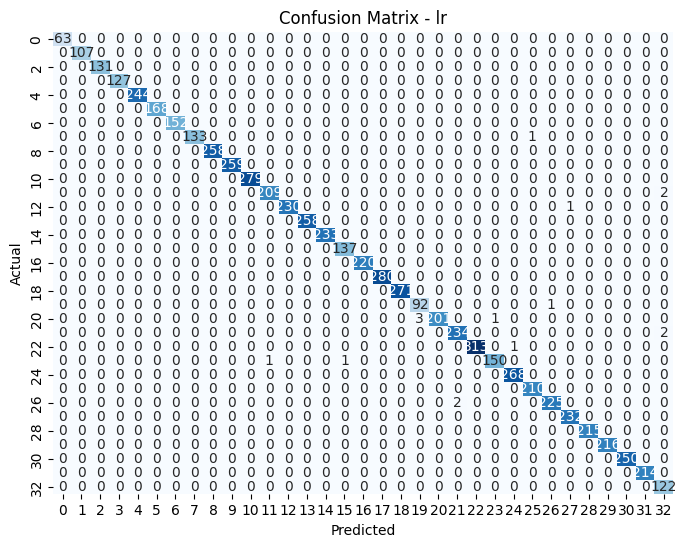


rc Evaluation:
Accuracy: 0.9883876730683341
Confusion Matrix:
[[ 63   0   0 ...   0   0   0]
 [  0 107   0 ...   0   0   0]
 [  0   0 131 ...   0   0   0]
 ...
 [  0   0   0 ... 250   0   0]
 [  0   0   0 ...   0 209   0]
 [  1   0   0 ...   0   0 118]]
Classification Report:
              precision    recall  f1-score   support

           a       0.98      1.00      0.99        63
           b       0.96      1.00      0.98       107
           c       0.98      1.00      0.99       131
           d       1.00      1.00      1.00       127
           e       0.99      1.00      1.00       244
           f       1.00      1.00      1.00       168
           g       1.00      1.00      1.00       152
           h       1.00      0.99      1.00       134
       hello       1.00      0.99      0.99       258
           i       0.98      1.00      0.99       259
  i_love_you       0.99      1.00      0.99       279
           j       1.00      0.95      0.97       211
           k       

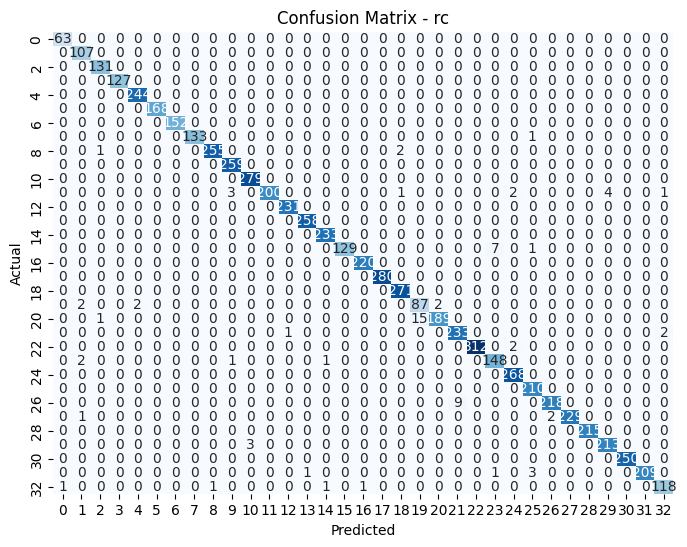


rf Evaluation:
Accuracy: 0.9962781003424148
Confusion Matrix:
[[ 63   0   0 ...   0   0   0]
 [  0 107   0 ...   0   0   0]
 [  0   0 130 ...   0   0   0]
 ...
 [  0   0   0 ... 249   0   0]
 [  0   0   0 ...   0 212   1]
 [  1   0   0 ...   0   0 121]]
Classification Report:
              precision    recall  f1-score   support

           a       0.97      1.00      0.98        63
           b       0.99      1.00      1.00       107
           c       1.00      0.99      1.00       131
           d       1.00      1.00      1.00       127
           e       1.00      1.00      1.00       244
           f       0.99      1.00      1.00       168
           g       0.99      1.00      0.99       152
           h       1.00      0.99      0.99       134
       hello       1.00      1.00      1.00       258
           i       1.00      1.00      1.00       259
  i_love_you       1.00      1.00      1.00       279
           j       0.98      0.99      0.98       211
           k       

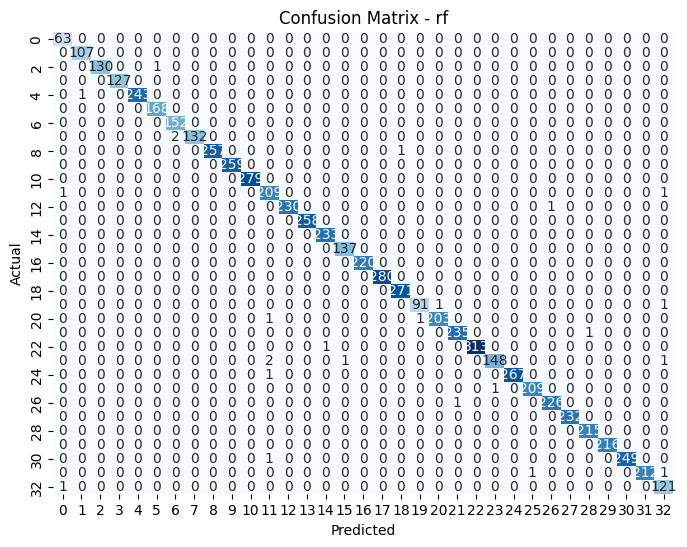


gb Evaluation:
Accuracy: 0.9937472085752568
Confusion Matrix:
[[ 60   0   0 ...   0   0   2]
 [  0 107   0 ...   0   0   0]
 [  0   0 130 ...   0   0   0]
 ...
 [  0   0   0 ... 249   0   0]
 [  0   0   0 ...   0 210   0]
 [  1   0   0 ...   0   0 117]]
Classification Report:
              precision    recall  f1-score   support

           a       0.98      0.95      0.97        63
           b       1.00      1.00      1.00       107
           c       1.00      0.99      1.00       131
           d       0.99      1.00      1.00       127
           e       0.99      1.00      0.99       244
           f       1.00      0.98      0.99       168
           g       0.99      1.00      0.99       152
           h       1.00      0.99      0.99       134
       hello       1.00      1.00      1.00       258
           i       1.00      1.00      1.00       259
  i_love_you       1.00      1.00      1.00       279
           j       0.97      1.00      0.98       211
           k       

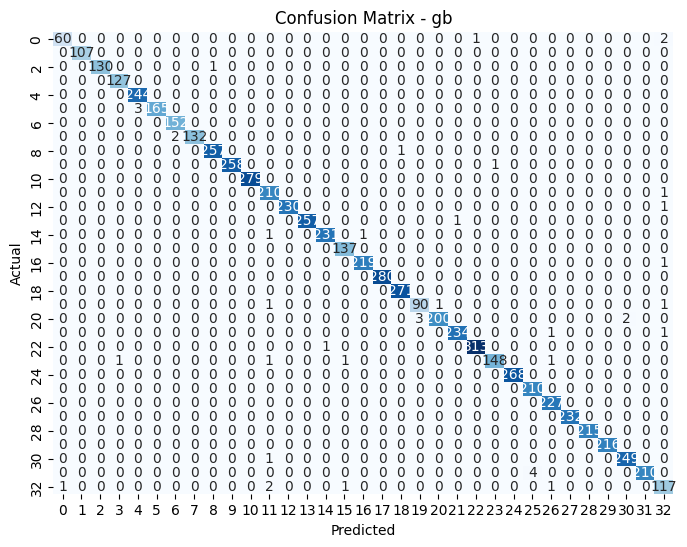

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Load data
df = pd.read_csv(r'D:\a\coords - Copy.csv')
X = df.drop('class', axis=1)  # features
y = df['class']  # target value

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Define pipelines
pipelines = {
    'lr': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('lr', LogisticRegression())]),
    'rc': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('rc', RidgeClassifier())]),
    'rf': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('rf', RandomForestClassifier())]),
    'gb': Pipeline([('s', SimpleImputer()), ('ss', StandardScaler()), ('gb', GradientBoostingClassifier())]),
}

# Create a dictionary to store evaluation results
evaluation_results = {}

# Fit models and select the best
best_accuracy = 0.0
best_classifier = ''
best_model = None
for name, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Store evaluation results
    evaluation_results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_mat,
        'classification_report': classification_rep
    }

    # Check if current model has better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = name
        best_model = model

# Save the best model
with open('body_language.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Print the best model and accuracy
print(f'The best model is {best_classifier} with accuracy {best_accuracy}.')

# Visualize evaluation results
for name, results in evaluation_results.items():
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")
    print(f"Classification Report:\n{results['classification_report']}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# Khởi tạo MediaPipe Holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Khởi tạo webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # Xử lý khung hình
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    
    # Chuyển lại màu của hình ảnh
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Lấy các điểm cơ thể
    right_hand_landmarks = results.right_hand_landmarks.landmark

    # Chuyển đổi các điểm đánh dấu thành đầu vào cho mô hình LSTM
    try:
        hand_input = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in right_hand_landmarks])
        hand_input = hand_input.reshape((1, hand_input.shape[0], hand_input.shape[1]))
            
            # Dự đoán ngôn ngữ ký hiệu
        prediction = model.predict(hand_input)
            
            # Hiển thị dự đoán
        cv2.putText(image, str(prediction), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    except:
        print("er!")
    
    # Hiển thị khung hình
    cv2.imshow('Webcam Feed', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [4]:
df = pd.read_csv(r'D:\a\coords - Copy.csv')

In [ ]:
df.fillna(0)

In [ ]:
df[df['class']=='h']

In [5]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)


In [7]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [11]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

## 3.3 Evaluate and Serialize Model 

In [11]:
from sklearn.metrics import accuracy_score
import pickle

In [14]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 0.9976179842191455
rc 0.9883876730683341
rf 0.9962781003424148
gb 0.9940449605478636


In [ ]:
with open('body_language.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

In [12]:
with open('body_language.pkl', 'rb') as f:
            model = pickle.load(f)

In [ ]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        results = holistic.process(image)
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        try:
            rh = results.right_hand_landmarks.landmark
            rh_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in rh]).flatten())
            row = rh_row
            X = pd.DataFrame([row])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, body_language_prob)
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        except:
            print("er!")
            pass
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()